In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


import torch
import torch.nn as nn

from utils.helper import fn_plot_torch_hist

In [119]:
###------------------------------
### global variables
##-----------------
RANDOM_STATE = 24
# np.random.RandomState(seed = RANDOM_STATE)
# nn.random.set_seed(RANDOM_STATE)
# rng= np.random.default_rng(seed= RANDOM_STATE)

N_SAMPLE  = 1000
NOISE = .2
ALPHA = .001
TEST_SIZE = .2
EPOCHS = 2000 #NO. of itersation used to optimize weights
# input and output directories

params = {'legend.fontsize' : 'medium', 
          'figure.figsize' : (15, 4),
          'axes.labelsize' : 'medium',
          'axes.titlesize' : 'large',
          'xtick.labelsize' : 'medium',
          'ytick.labelsize' : 'medium',
         }
loss_hist = {} # creating an empty dictionary which will store loss and epoch later so that we can make loss curve later

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm

# plt.style.use('seaborn-v0_8-darkgrid')

plt.style.use('ggplot')

In [121]:
## Machine specific code

# physical_device = tf.config.list_physical_devices('GPU')

# if len(physical_device) >0:
    # tf.config.experimental.set_memory_growth(physical_device[0],True)


In [123]:
X, y = datasets.make_moons(n_samples = N_SAMPLE, # n_samples: how many datasets in it
                          noise = NOISE, # peportion of randommness added to data so that it matched to real life data , without noise it becomes perfect half circle in moon dataset
                          shuffle = True, 
                          random_state = RANDOM_STATE)
X.shape, y.shape

((1000, 2), (1000,))

In [124]:
X_train, X_test, y_train, y_test=   train_test_split(X,y , random_state= RANDOM_STATE, stratify=y, test_size= TEST_SIZE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [125]:
torch.cuda.is_available()

False

In [126]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device # manually set device in pytorch 

'cpu'

## making model using pytorch

In [128]:
input_dim = X_train.shape[1]
# input is not passsed as list here
model = nn.Sequential(  ## nn stand for neural network torch.nn

    nn.Linear(input_dim, 5), # no of neurons=5
    nn.ReLU(), # activation function
    nn.Linear(5, 5), # no of neurons=5, no. of input 5
    nn.ReLU(), 
    nn.Linear(5, 4), # no of neurons=4, no of input 5
    nn.ReLU(), 
    nn.Linear(4, 3), 
    nn.ReLU(), 
    nn.Linear(3, 2)
    ).to(device = device) 

In [133]:
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): ReLU()
  (8): Linear(in_features=3, out_features=2, bias=True)
)

In [134]:
# we have to convert datatype from numpy to tensor in torch
# moving all the training data to device
train_X = torch.tensor(X_train, dtype = torch.float32, device = device) #float32 is the min data precision which can give us good result, tensor flow automatically
# device= device means we are putting it to the available device
train_y = torch.tensor(y_train, dtype = torch.int64, device = device) 


test_X = torch.tensor(X_test, dtype = torch.float32, device = device)
test_y = torch.tensor(y_test, dtype = torch.int64, device = device)

In [135]:
train_X

tensor([[ 2.1581, -0.2587],
        [-0.2726,  1.0721],
        [-1.0524,  0.4215],
        ...,
        [ 1.0922, -0.6233],
        [ 0.7624, -0.4503],
        [ 0.9277,  0.1778]])

`optimizer.zero_grad()` clears the gradients of all the parameters that the optimizer is managing. Gradients are accumulated in PyTorch by default during the backward pass (when you call loss.backward()), so this step ensures that the gradients don’t mix between different training iterations.

`optimizer.step()` uses the gradients that were calculated during the backward pass `(loss.backward())` to adjust the parameters of the model.
The adjustments are based on the optimization algorithm (e.g., SGD, Adam, etc.) and its hyperparameters (e.g., learning rate, momentum).

In [138]:
### defining loss function # just  like compile of tensorflow
loss_fn = nn.CrossEntropyLoss()

#Adam needs two parameters over each weight
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)# lr is learning rate

for epoch in range(EPOCHS):
    model.train() #model.train() means that we are using model in train mode thoufh if use model directly then default is also train
    # we have to do this because wiegrhs gets updated onlu in training mode
    predict_proba = model(train_X)
    curr_loss = loss_fn(predict_proba, train_y)
    
    #Backpropagation , just like fit part of tensorflow
    optimizer.zero_grad() # because tensors are immutable we can't change them  # it resets the values in the GPU as tensors are immutable
    curr_loss.backward()
    optimizer.step() # according to optimizer , move one step

In [139]:
output

tensor([[0.1713, 0.7288],
        [0.5760, 0.1255],
        [0.5760, 0.1255],
        ...,
        [0.1713, 0.7288],
        [0.1713, 0.7288],
        [0.2811, 0.5342]], grad_fn=<AddmmBackward0>)

In [140]:
output = model(train_X)
y_pred = torch.argmax(output, dim = 1).cpu().numpy()#dim is like axis in dataframe, .cpu()  moves to cpu, converted to numpy
y_pred

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [142]:
from sklearn.metrics import classification_report
print(classification_report(train_y.cpu().numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.98      0.98      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [151]:
del model
model = nn.Sequential(  ## nn stand for neural network torch.nn

    nn.Linear(input_dim, 5), # no of neurons=5
    nn.ReLU(), # activation function
    nn.Linear(5, 5), # no of neurons=5, no. of input 5
    nn.ReLU(), 
    nn.Linear(5, 4), # no of neurons=4, no of input 5
    nn.ReLU(), 
    nn.Linear(4, 3), 
    nn.ReLU(), 
    nn.Linear(3, 2)
    ).to(device = device) 

In [199]:
### defining loss function # just  like compile of tensorflow
loss_fn = nn.CrossEntropyLoss()

#Adam needs two parameters over each weight
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)# lr is learning rate

#list to collect the progress
loss =[]
tloss = []
n_epoch = []
acc = []
tacc = [] # testing accuracy

for epoch in range(EPOCHS):
    model.train() #model.train() means that we are using model in train mode thoufh if use model directly then default is also train
    # we have to do this because wiegrhs gets updated onlu in training mode
    predict_proba = model(train_X)
    curr_loss = loss_fn(predict_proba, train_y)
    
    #Backpropagation , just like fit part of tensorflow
    optimizer.zero_grad() # because tensors are immutable we can't change them  # it resets the values in the GPU as tensors are immutable
    curr_loss.backward()
    optimizer.step() # according to optimizer , move one step

    loss.append(curr_loss.data.item())

    y_pred = torch.argmax(predict_proba, 1).cpu().numpy() # torch.max gives value and index , 1 is axis

    curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)

    acc.append(curr_acc)

    model.eval() 
    test_proba = model(test_X)
    test_loss = loss_fn(test_proba, test_y)
    tloss.append(test_loss.data.item())

    y_pred = torch.argmax(test_proba, 1) # torch.max gives value and index , 1 is axis
    test_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
    tacc.append(test_acc)

    n_epoch.append(epoch)

    if epoch % 500 == 0:
        print(f'Epoch: {epoch:>5d} |Loss: {curr_loss:.5f}/{test_loss:.5f} | ACC: {curr_acc: .5f}/{test_acc: .5f}')

Epoch:     0 |Loss: 0.04874/0.11355 | ACC:  0.98250/ 0.96000
Epoch:   500 |Loss: 0.04867/0.11964 | ACC:  0.98375/ 0.96000
Epoch:  1000 |Loss: 0.04857/0.12028 | ACC:  0.98500/ 0.96000
Epoch:  1500 |Loss: 0.04849/0.11885 | ACC:  0.98375/ 0.96000


In [201]:
len(n_epoch)

2000

In [202]:
hist_df = pd.DataFrame({'epoch': n_epoch,
                        'loss': loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_Acc': tacc})

In [211]:
hist_df

,epoch,loss,test_loss,acc,test_Acc
0,0,0.048736,0.113554,0.98250,0.96
1,1,0.049707,0.118324,0.98500,0.96
2,2,0.048866,0.124407,0.98375,0.96
3,3,0.048934,0.127462,0.98500,0.96
4,4,0.049272,0.126808,0.98500,0.96
...,...,...,...,...,...
1995,1995,0.048436,0.120000,0.98500,0.96
1996,1996,0.048450,0.119210,0.98500,0.96
1997,1997,0.048435,0.118651,0.98500,0.96
1998,1998,0.048419,0.118366,0.98375,0.96


,epoch,loss,test_loss,acc,test_Acc
0,0,0.048736,0.113554,0.98250,0.96
1,1,0.049707,0.118324,0.98500,0.96
2,2,0.048866,0.124407,0.98375,0.96
3,3,0.048934,0.127462,0.98500,0.96
4,4,0.049272,0.126808,0.98500,0.96


<Axes: >

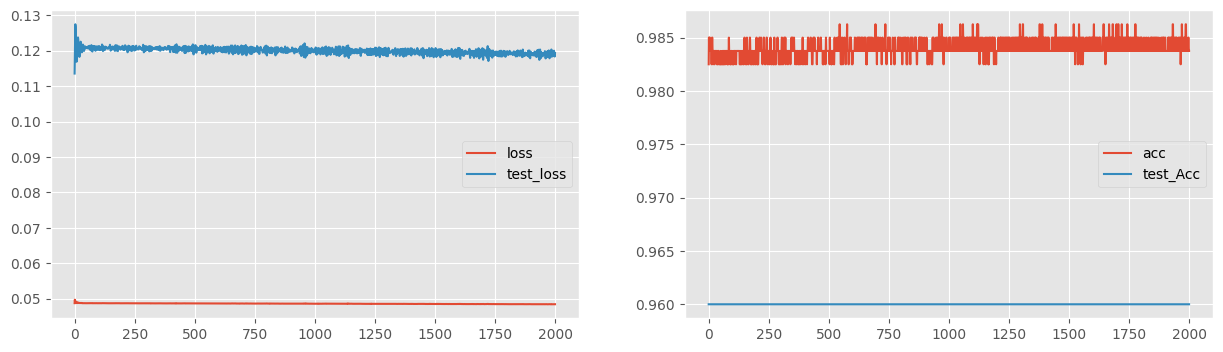

In [213]:
display(hist_df.head())
fig, ax = plt.subplots(1,2)

# the required plot
hist_df.plot(y= ['loss','test_loss'], ax= ax[0])
hist_df.plot(y= ['acc','test_Acc'], ax= ax[1])

In [ ]:
# define loss function
#criterias: on what we are defining loss , 
#sparse means: input is column vector, 
#check y and y_pred same or not
# from_logits = True means i did not put sigmoid or softmax at the last layer, google will automatically handle it.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [ ]:
loss_fn(y_train[:1], prediction).numpy()

In [ ]:
#for classification : metrics = accuracy
model.compile(optimizer = 'adam', loss= loss_fn, metrics= ['accuracy'])

In [ ]:
# model fitting 
# supply x, y and validation data , at each epoch check how model is doing on validation

history =  model.fit(x= X_train, y=y_train, validation_data= [X_test, y_test], epochs= EPOCHS)

In [ ]:
# keep eye on loss , epoch after epoch it should go down , no harm at one or two places
# trainng loss goes up then problem
# even spikes come then check your model
# validation loss coming up then we think it is overfitting
# like if we keep epoch =2000 here then overfitting

In [ ]:
history.history.keys() # tensor flow output is a dictionary, here: history.history, history is object
# .history is an attribute of history 

In [ ]:
dir(history)

In [ ]:
history.history  
#dictionary

In [ ]:
hist_df= pd.DataFrame(history.history)
display(hist_df.head())
fig, ax = plt.subplots(1,2)

# the required plot
hist_df.plot(y= ['loss','val_loss'], ax= ax[0])
hist_df.plot(y= ['accuracy','val_accuracy'], ax= ax[1])

In [ ]:
fn_plot_tf_hist(hist_df=hist_df) #Using function

In [ ]:
y_pred = model.predict(X_train)
accuracy_score(y_train, y_pred.argmax(axis=1))

In [ ]:
cm = confusion_matrix(y_train, y_pred.argmax(axis=1))
plost = ConfusionMatrixDisplay(cm, display_labels = [0,1])
fig, ax = plt.subplots(figsize = (4,4))

plost.plot(ax = ax, cmap = 'Blues', colorbar = False)
ax.grid(False)

In [ ]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred.argmax(axis = 1))

In [ ]:
cm = confusion_matrix(y_test, y_pred.argmax(axis = 1))
plat = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
fig, ax =plt.subplots(figsize = (4,4))

plat.plot(ax = ax, cmap = 